In [156]:
# Environment Setup and Data Loading
import time
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt  
import seaborn as sns  
from sklearn import tree
from sklearn.model_selection import train_test_split, StratifiedKFold,GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import sys
import site
import os

# Check the kernel with these if having issues with the environment

#print("Python executable:", sys.executable)
#print("Python version:", sys.version)
#print("Site packages:", site.getsitepackages())


# Jupyter Notebook depedendency
# %matplotlib inline

data = './diabetes_data.csv'
if os.path.exists(data):
    print("Data has been loaded.")
else:
    print("An error while loading the file occurred. Check the file path.")

try:
    # Assume the first line are the headers and save them in a list
    df = pd.read_csv(data, header=0)
    col_names = df.columns.tolist()
    print("Headers:", col_names)
    print(df.head())
except Exception as e:
    print(f"An error while loading the file occurred: {e}")


Data has been loaded.
Headers: ['Age', 'Sex', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Stroke', 'HighBP', 'Diabetes']
   Age  Sex  HighChol  CholCheck  BMI  Smoker  HeartDiseaseorAttack  \
0    4    1         0          1   26       0                     0   
1   12    1         1          1   26       1                     0   
2   13    1         0          1   26       0                     0   
3   11    1         1          1   28       1                     0   
4    8    0         0          1   29       1                     0   

   PhysActivity  Fruits  Veggies  HvyAlcoholConsump  GenHlth  MentHlth  \
0             1       0        1                  0        3         5   
1             0       1        0                  0        3         0   
2             1       1        1                  0        1         0   
3             1       1     

In [157]:
#get column names and also informations about dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70692 entries, 0 to 70691
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   Age                   70692 non-null  int64
 1   Sex                   70692 non-null  int64
 2   HighChol              70692 non-null  int64
 3   CholCheck             70692 non-null  int64
 4   BMI                   70692 non-null  int64
 5   Smoker                70692 non-null  int64
 6   HeartDiseaseorAttack  70692 non-null  int64
 7   PhysActivity          70692 non-null  int64
 8   Fruits                70692 non-null  int64
 9   Veggies               70692 non-null  int64
 10  HvyAlcoholConsump     70692 non-null  int64
 11  GenHlth               70692 non-null  int64
 12  MentHlth              70692 non-null  int64
 13  PhysHlth              70692 non-null  int64
 14  DiffWalk              70692 non-null  int64
 15  Stroke                70692 non-null  int64
 16  High

In [158]:
#Check unique values - good for multicollinearity

unique_values = {}
for col in df.columns:
    unique_values[col] = df[col].value_counts().shape[0]
pd.DataFrame(unique_values, index=['unique value count']).transpose().sort_values(by='unique value count', ascending=False)

,unique value count
BMI,80
PhysHlth,31
MentHlth,31
Age,13
GenHlth,5
HvyAlcoholConsump,2
HighBP,2
Stroke,2
DiffWalk,2
Veggies,2


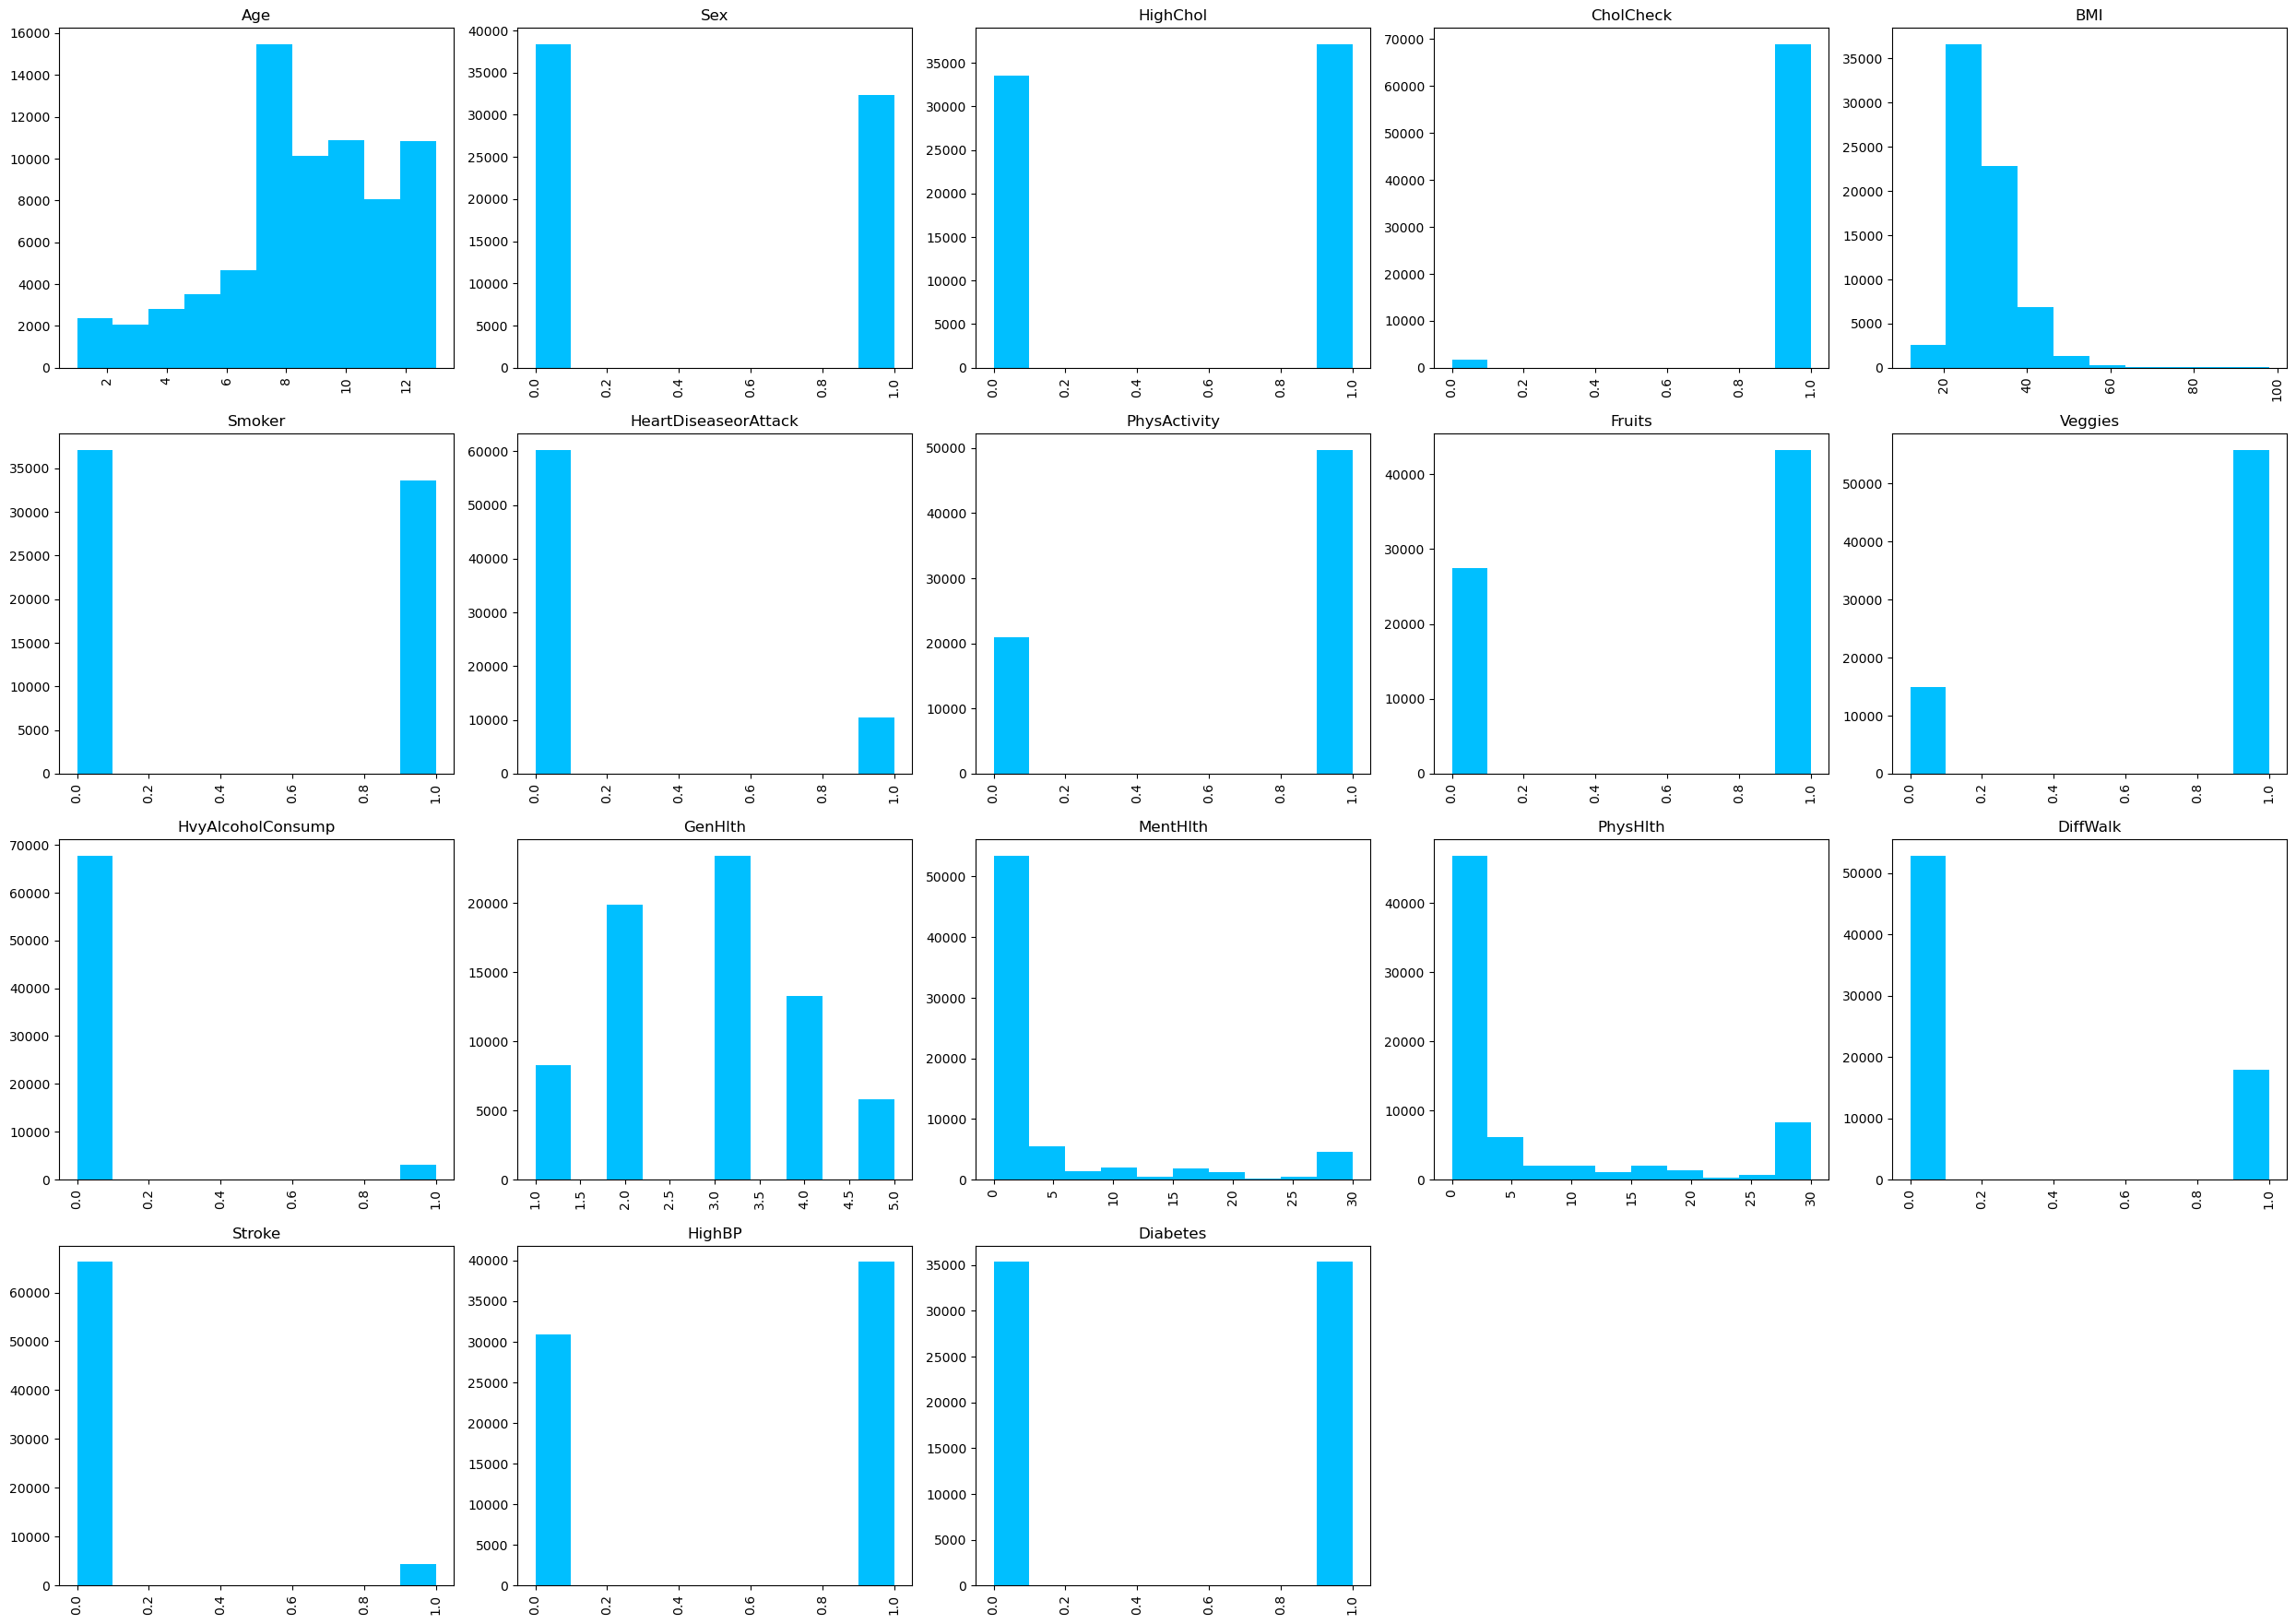

In [159]:
#Check frequency of all values in the column

feature_cols = [x for x in df.columns if x not in 'stroke']
plt.figure(figsize=(25,35))
# loop for subplots
for i in range(len(feature_cols)):
    plt.subplot(8,5,i+1)
    plt.title(feature_cols[i])
    plt.xticks(rotation=90)
    plt.hist(df[feature_cols[i]],color = "deepskyblue")
    
plt.tight_layout()

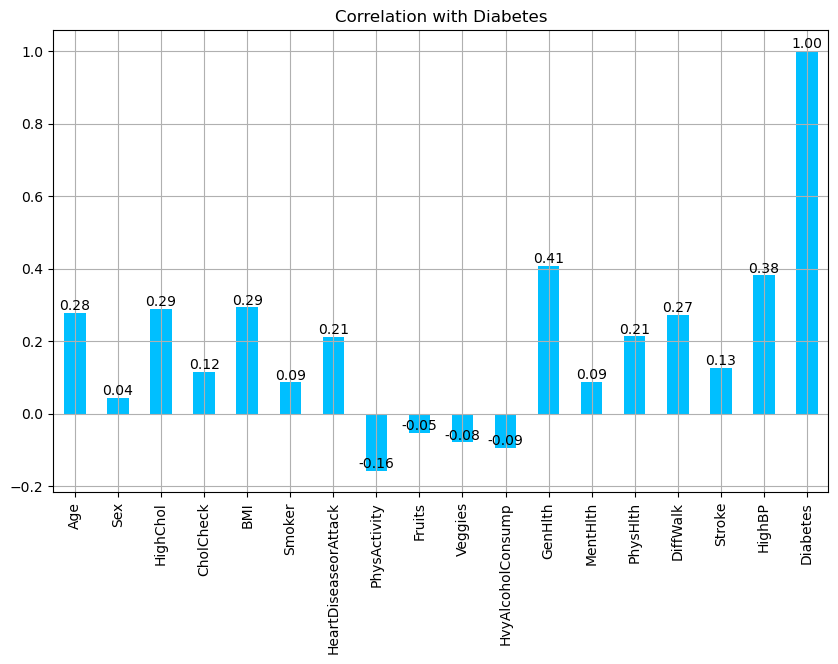

In [160]:
# Check correlation of other columns with diabetes column with Pearson Correlation
numerical_cols = df.select_dtypes(include=['number']).columns
ax = df[numerical_cols].corrwith(df['Diabetes']).plot(kind='bar', grid=True, figsize=(10, 6), title="Correlation with Diabetes", color="deepskyblue");
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')


In [ ]:
### Variables with correlation less than 0.1 are Sex, Smoker, Fruits, Veggies, HvyAlcoholConsump, MentHlth.

<Axes: title={'center': 'Feature Correlation Heatmap'}>

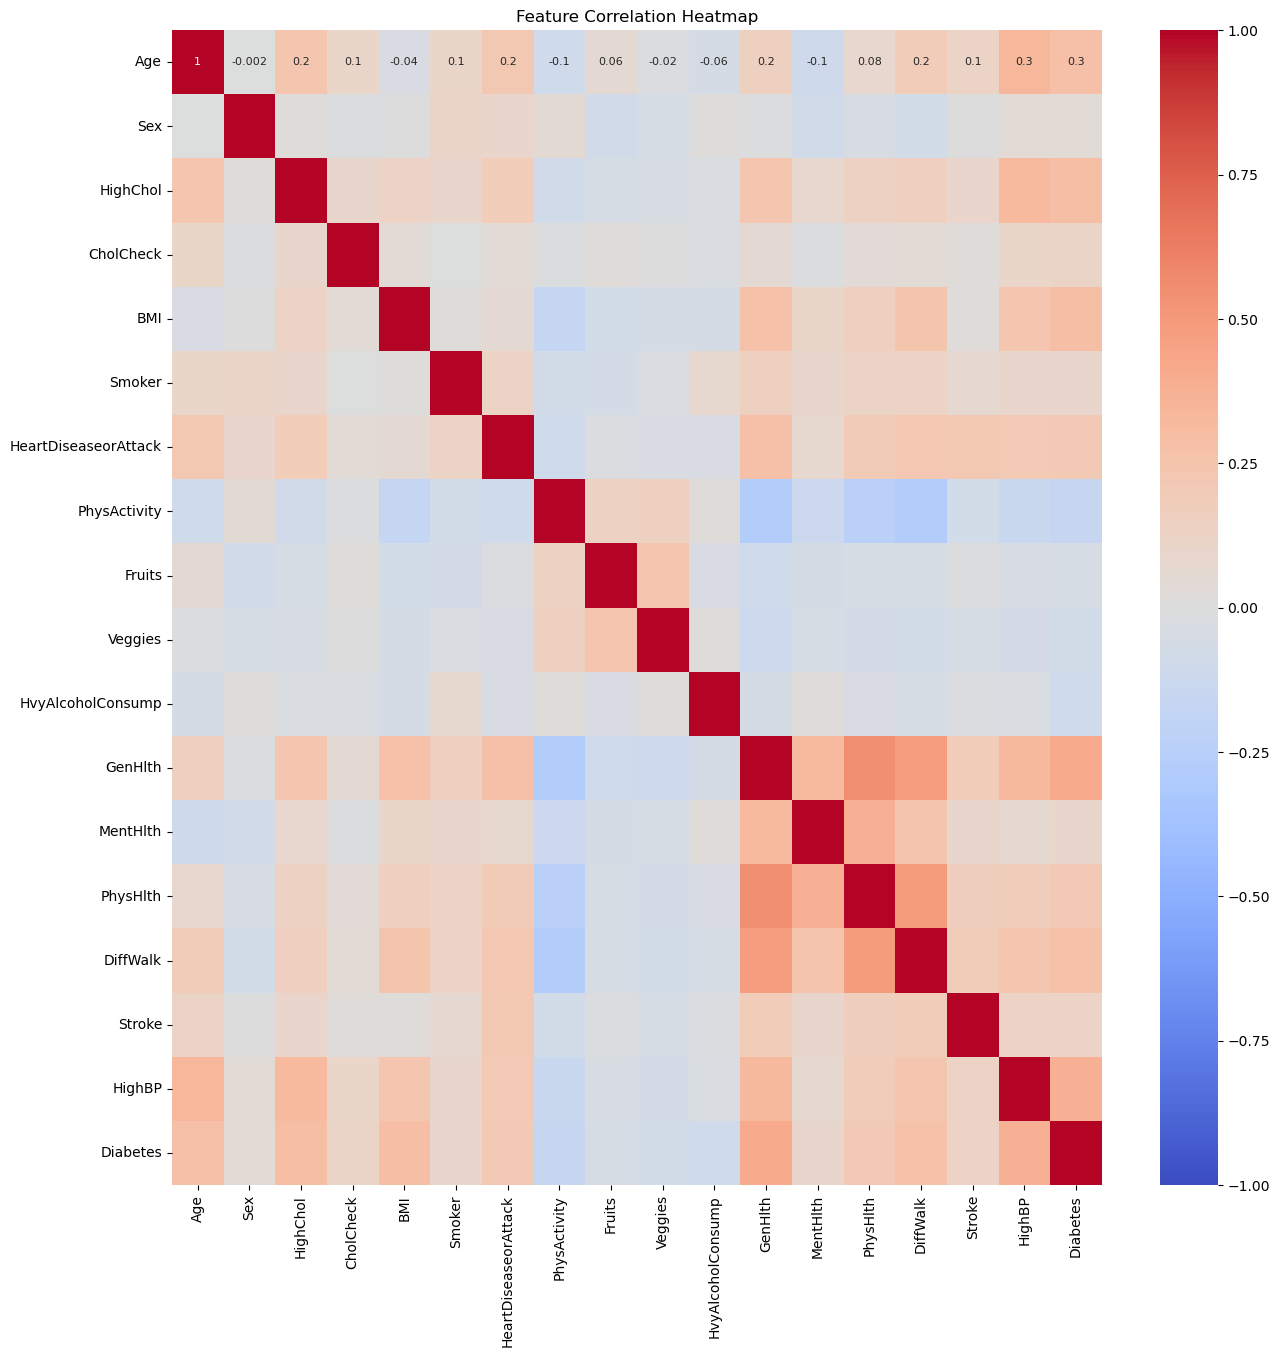

In [161]:
# Correlation between any two features
# check for possible co-variates

#sns.set(rc = {'figure.figsize':(10,10)})
#sns.heatmap(df.corr(),vmin=-1, vmax=1, annot = True, fmt='.1g',cmap= 'coolwarm')

### The seaborn .set is deprecated duo to changes in seaborn api. We can use the following instead 

plt.figure(figsize=(15,15))
plt.title('Feature Correlation Heatmap')
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, annot_kws={'size': 8}, fmt='.1g', cmap='coolwarm')



In [162]:
df.isnull().sum()

Age                     0
Sex                     0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Stroke                  0
HighBP                  0
Diabetes                0
dtype: int64

In [164]:
#Data splitting
# split X and y into training and testing sets


y = (df['Diabetes']).astype(int)
X = df.loc[:, df.columns != 'Diabetes'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) #80% train 
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (56553, 17) Test shape: (14139, 17)


In [ ]:
# This approach is a fixed one

#DecisionTreeClassifier instance with model with gini index/impurity 
#random_state keeps the same state every run | max_depth is the maximum depth of the tree
# from sklearn.tree import DecisionTreeClassifier
# clf_gini = DecisionTreeClassifier(criterion='gini', max_depth=7, random_state=0)

# Train/fit the model
# X_train is the input, and y_train is the output
# clf_gini.fit(X_train, y_train)


# This approach is a dynamic one using hyperparameter tuninng
# Parameters to tune: max_depth, min_samples_split, min_samples_leaf, criterion.


param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

clf = DecisionTreeClassifier(random_state=42)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)

# Update clf_gini with best model
clf_gini = grid_search.best_estimator_

# This tests multiple configurations across 5-fold cross-validation, selecting the best-performing model. Use this tuned clf_gini for subsequent steps.



Best parameters: {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 4, 'min_samples_split': 2}
Best cross-validation accuracy: 0.7412339341506249


In [166]:
# Ablation testing
# Test different depths and constraints to simulate adding/removing layers.


# depths = [1, 3, 5, 7, None]  # None = no limit on depth
# results = []

# for depth in depths:
#     clf = DecisionTreeClassifier(criterion='gini', max_depth=depth, random_state=42)
#     clf.fit(X_train, y_train)
#     y_pred = clf.predict(X_test)
#     acc = accuracy_score(y_test, y_pred)
#     results.append((depth, acc))
# for depth, acc in results:
#     print(f"Max Depth: {depth}, Test Accuracy: {acc:.4f}")

# NOTE The variable clf is redefined in each loop iteration with a new DecisionTreeClassifier instance. After the loop ends, clf holds the last model (depth=None), but this doesn’t affect clf_gini from your previous hyperparameter tuning cell (where clf_gini was set to the best model with max_depth=7).
# NOTE Key Point: This cell doesn’t update clf_gini—it’s just testing different depths and printing results. The main model (clf_gini) remains unchanged unless you explicitly reassign it.

depths = [1, 3, 5, 7, None]
for depth in depths:
    clf = DecisionTreeClassifier(criterion='gini', max_depth=depth, min_samples_leaf=4, min_samples_split=2, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(f"Max Depth: {depth}, Accuracy: {accuracy_score(y_test, y_pred):.4f}")

Max Depth: 1, Accuracy: 0.6793
Max Depth: 3, Accuracy: 0.7137
Max Depth: 5, Accuracy: 0.7306
Max Depth: 7, Accuracy: 0.7395
Max Depth: None, Accuracy: 0.6838


In [150]:
# Scalability testing
#test training time with dataset size or tree depth.



sizes = [0.25, 0.5, 0.75, 1.0]  # Fractions of training data
depths = [3, 5, 7, 10]
times = []

for size in sizes:
    for depth in depths:
        X_subset = X_train.sample(frac=size, random_state=42)
        y_subset = y_train.loc[X_subset.index]
        clf = DecisionTreeClassifier(criterion='gini', max_depth=depth,  min_samples_leaf=4, min_samples_split=2, random_state=42)
        start = time.time()
        clf.fit(X_subset, y_subset)
        end = time.time()
        times.append((size, depth, end - start))
for size, depth, t in times:
    print(f"Data Fraction: {size}, Depth: {depth}, Time: {t:.4f} seconds")

Data Fraction: 0.25, Depth: 3, Time: 0.0109 seconds
Data Fraction: 0.25, Depth: 5, Time: 0.0097 seconds
Data Fraction: 0.25, Depth: 7, Time: 0.0266 seconds
Data Fraction: 0.25, Depth: 10, Time: 0.0225 seconds
Data Fraction: 0.5, Depth: 3, Time: 0.0215 seconds
Data Fraction: 0.5, Depth: 5, Time: 0.0334 seconds
Data Fraction: 0.5, Depth: 7, Time: 0.0406 seconds
Data Fraction: 0.5, Depth: 10, Time: 0.0481 seconds
Data Fraction: 0.75, Depth: 3, Time: 0.0291 seconds
Data Fraction: 0.75, Depth: 5, Time: 0.0470 seconds
Data Fraction: 0.75, Depth: 7, Time: 0.0561 seconds
Data Fraction: 0.75, Depth: 10, Time: 0.0730 seconds
Data Fraction: 1.0, Depth: 3, Time: 0.0397 seconds
Data Fraction: 1.0, Depth: 5, Time: 0.0600 seconds
Data Fraction: 1.0, Depth: 7, Time: 0.0770 seconds
Data Fraction: 1.0, Depth: 10, Time: 0.1131 seconds


In [151]:
# Stratified K-Folds with 10 runs on Dataset 1


metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}
for seed in range(10):  # Note 1
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)  # Note 2
    for train_idx, test_idx in skf.split(X, y):
        X_train_fold, X_test_fold = X.iloc[train_idx], X.iloc[test_idx]
        y_train_fold, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]
        
        # Note 3: 
        X_train_sub, X_val, y_train_sub, y_val = train_test_split(X_train_fold, y_train_fold, test_size=0.1, random_state=seed, stratify=y_train_fold)
        
        clf = DecisionTreeClassifier(**grid_search.best_params_, random_state=seed)
        clf.fit(X_train_sub, y_train_sub)
        y_pred = clf.predict(X_test_fold)
        
        metrics['accuracy'].append(accuracy_score(y_test_fold, y_pred))
        report = classification_report(y_test_fold, y_pred, output_dict=True)
        metrics['precision'].append(report['1']['precision'])
        metrics['recall'].append(report['1']['recall'])
        metrics['f1'].append(report['1']['f1-score'])

# Note 5: Mean and Std
for metric, values in metrics.items():
    print(f"{metric.capitalize()} - Mean: {np.mean(values):.4f}, Std: {np.std(values):.4f}")

Accuracy - Mean: 0.7405, Std: 0.0037
Precision - Mean: 0.7222, Std: 0.0088
Recall - Mean: 0.7825, Std: 0.0171
F1 - Mean: 0.7509, Std: 0.0047


In [153]:
#  Standard evaluation metrics on the 20% of data

y_pred_gini = clf_gini.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred_gini, target_names=['No Diabetes', 'Diabetes']))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_gini))

Classification Report:
              precision    recall  f1-score   support

 No Diabetes       0.76      0.71      0.73      7070
    Diabetes       0.73      0.77      0.75      7069

    accuracy                           0.74     14139
   macro avg       0.74      0.74      0.74     14139
weighted avg       0.74      0.74      0.74     14139

Confusion Matrix:
[[5003 2067]
 [1616 5453]]


In [155]:
# Compare with state-of-the-art model
# Train Random Forest
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)

# Compare accuracies
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_gini))
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf, target_names=['No Diabetes', 'Diabetes']))

Decision Tree Accuracy: 0.7395148171723601
Random Forest Accuracy: 0.7232477544380791
Random Forest Classification Report:
              precision    recall  f1-score   support

 No Diabetes       0.74      0.69      0.71      7070
    Diabetes       0.71      0.76      0.73      7069

    accuracy                           0.72     14139
   macro avg       0.72      0.72      0.72     14139
weighted avg       0.72      0.72      0.72     14139



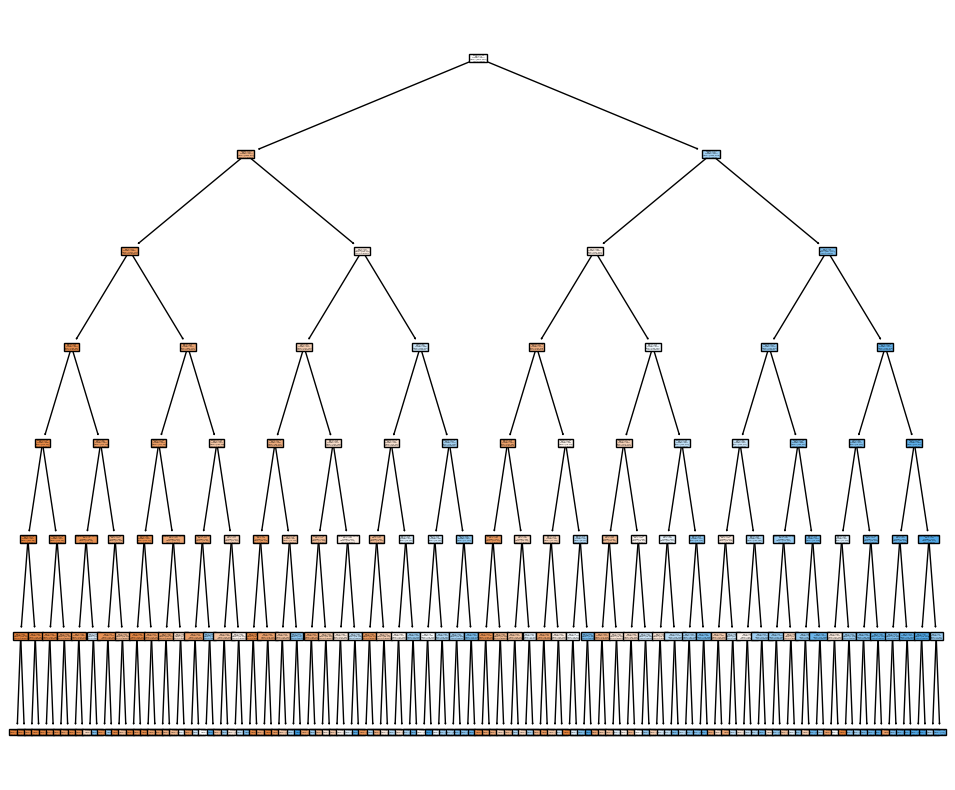

In [136]:

# plt.figure(figsize=(12,8))
# tree.plot_tree(clf_gini.fit(X_train, y_train)) 

plt.figure(figsize=(12,10))
tree.plot_tree(clf_gini, feature_names=X_train.columns, class_names=['No Diabetes', 'Diabetes'], filled=True)
plt.show()